## Baseline Classification (no oversampling, no validation)

After having created our synthetic dataset and having found our train and test set it is now time to train our first classification models and test their performance. This has to be intended as  a preliminary section in which we don't deal with many of the problems of credit card fraud detection, as for example the imbalance classification. Moreover we don't perform any cross validation to find best hyperparameters. All this matters will be discussed in later sections

The training of a prediction model consists in finding the mathematical relationship that exists between two sets of features, called *input* and *output* features. In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraudulent or genuine (the output feature), using features that characterize the transactions (the input features).




Let's first add our previously created imports and functions

In [68]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
!curl -O https://github.com/leonardoimperit/thesis-timperi/shared_functions_imports.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31568  100 31568    0     0   290k      0 --:--:-- --:--:-- --:--:--  290k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     9  100     9    0     0    160      0 --:--:-- --:--:-- --:--:--   163


In [69]:
#mounting google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As usual, we first have to load our datasets: in this case the training and the test set

In [70]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/train&test/train/' 

BEGIN_DATE = "2018-05-06" #remember to align this dates with the train dates and test dates on the feature_transormation notebook
END_DATE = "2018-07-20"

print("Load  files")
%time train_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(train_df),train_df.TX_FRAUD.sum()))


Load  files
CPU times: user 681 ms, sys: 223 ms, total: 904 ms
Wall time: 1.44 s
728537 transactions loaded, containing 6405 fraudulent transactions


In [71]:
DIR_INPUT='/content/drive/MyDrive/Colab Notebooks/tesi/ready for repository/train&test/test/' 

BEGIN_DATE = "2018-07-28" #remember to align this dates with the train dates and test dates on the feature_transormation notebook
END_DATE = "2018-09-09"

print("Load  files")
%time test_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(test_df),test_df.TX_FRAUD.sum()))


Load  files
CPU times: user 193 ms, sys: 42.3 ms, total: 235 ms
Wall time: 345 ms
158744 transactions loaded, containing 951 fraudulent transactions


In [72]:
train_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,335910,2018-05-06 00:00:02,161,2288,89.52,3024002,35,0,0,1,1,4.0,88.9925,18.0,71.688333,78.0,70.171282,0.0,0.0,11.0,0.0,24.0,0.0
1,335911,2018-05-06 00:03:30,4981,7993,87.16,3024210,35,0,0,1,1,4.0,95.0825,23.0,85.596087,72.0,91.660833,0.0,0.0,9.0,0.0,21.0,0.0
2,335912,2018-05-06 00:03:37,3013,117,16.79,3024217,35,0,0,1,1,1.0,16.7900,19.0,45.395263,72.0,23.702500,2.0,0.0,9.0,0.0,25.0,0.0
3,335913,2018-05-06 00:04:04,3496,5696,29.14,3024244,35,0,0,1,1,6.0,28.1750,25.0,31.430400,112.0,29.111875,1.0,0.0,7.0,0.0,25.0,0.0
4,335914,2018-05-06 00:04:13,1360,7152,47.80,3024253,35,0,0,1,1,4.0,56.0050,21.0,53.183810,88.0,44.410227,1.0,0.0,5.0,0.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728532,1064442,2018-07-20 23:56:48,1981,4332,150.79,9590208,110,0,0,0,0,3.0,139.8600,12.0,120.909167,47.0,94.228723,2.0,0.0,6.0,0.0,32.0,0.0
728533,1064443,2018-07-20 23:58:10,3843,1935,11.88,9590290,110,0,0,0,0,2.0,10.3000,8.0,10.073750,38.0,8.027895,0.0,0.0,6.0,0.0,23.0,0.0
728534,1064444,2018-07-20 23:58:15,3098,3401,26.86,9590295,110,0,0,0,0,2.0,14.8050,14.0,14.647143,52.0,14.422308,0.0,0.0,7.0,0.0,28.0,0.0
728535,1064445,2018-07-20 23:59:41,1187,2396,119.97,9590381,110,0,0,0,0,4.0,82.5025,20.0,90.171000,83.0,79.875422,0.0,0.0,2.0,0.0,19.0,0.0


In [73]:
test_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1131345,2018-07-28 00:04:06,4076,5478,87.27,10195446,118,0,0,1,1,1.0,87.270000,9.0,76.427778,31.0,69.035484,1.0,0.0,3.0,0.0,26.0,0.038462
1,1131347,2018-07-28 00:06:13,22,772,28.45,10195573,118,0,0,1,1,5.0,29.096000,25.0,29.933200,75.0,33.933333,1.0,0.0,1.0,0.0,25.0,0.000000
2,1131349,2018-07-28 00:09:07,1197,5685,78.99,10195747,118,0,0,1,1,2.0,64.155000,17.0,66.239412,75.0,68.390267,2.0,0.0,9.0,0.0,28.0,0.000000
3,1131350,2018-07-28 00:10:24,4736,7234,108.61,10195824,118,0,0,1,1,2.0,104.885000,19.0,57.865263,91.0,56.763516,1.0,0.0,10.0,0.0,34.0,0.000000
4,1131353,2018-07-28 00:12:01,3817,5544,54.97,10195921,118,0,0,1,1,4.0,74.687500,22.0,65.509091,88.0,64.829205,2.0,0.0,3.0,0.0,19.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158739,1552672,2018-09-09 23:36:50,2347,9207,24.03,13995410,161,0,0,1,0,1.0,24.030000,18.0,18.851667,76.0,16.158421,1.0,0.0,5.0,0.0,40.0,0.000000
158740,1552678,2018-09-09 23:41:26,4436,9809,18.75,13995686,161,0,0,1,0,3.0,78.920000,26.0,76.202308,117.0,74.788889,1.0,0.0,7.0,0.0,35.0,0.028571
158741,1552689,2018-09-09 23:47:32,303,3242,129.96,13996052,161,0,0,1,0,4.0,108.947500,12.0,84.105000,59.0,62.976441,1.0,0.0,4.0,0.0,14.0,0.000000
158742,1552696,2018-09-09 23:51:58,4849,1437,3.43,13996318,161,0,0,1,0,3.0,47.916667,23.0,78.292609,95.0,88.832842,1.0,0.0,5.0,0.0,32.0,0.000000


## Model training 1: Decision tree
We will first define the input and output features as follows:

* The output feature will be the transaction label `TX_FRAUD`
* The input features will be the transaction amount `TX_AMOUNT`, as well as all the features that were computed in the previous section, which characterize the context of a transaction.

In [74]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In [75]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data (this was not covered in the previous section). Here we employ a very simple standardScaler
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

As an example, let us train a small decision tree (with a maximum depth of 2). We first create a decision tree object (`sklearn.tree.DecisionTreeClassifier`), and call the `fit_model_and_get_predictions_dictionary` to train the decision tree, and get the predictions on the training and test sets.

In [76]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False) #no need to scale for decision tree

## performance assessment

Let us finally assess the performance of this decision tree model. We will compute three performance metrics: The AUC ROC, Average Precision (AP), and Card Precision top-$k$ (CP@k). The motivation for these three metrics will be covered in [Chapter 4](Performance_Metrics). For now, it is sufficient to know that

* The Card Precision top-$k$ is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of $k$ potentially fraudulent cards per day. It is computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the $k$ cards whose transactions have the highest fraud probabilities. The precision (proportion of actual frauded cards out of predicted frauded cards) is then computed for each day. The Card Precision top-$k$ is the average of these daily precisions. The number $k$ will be set to $100$ (that is, it is assumed that only 100 cards can be checked every day). 
* The Average Precision is a proxy for the Card Precision top-$k$, that integrates precisions for all possible $k$ values. 
* The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher $k$ values. It is less relevant in practice since the performances that matter most are those for low $k$ values. We however also report it since it is the most widely used performance metric for fraud detection in the literature. 

Note that all three metrics provide values in the interval $[0,1]$, and that higher values mean better performances. 




In [77]:
model_and_predictions_dictionary

{'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=2, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'prediction_execution_time': 0.024343013763427734,
 'predictions_test': array([0.00347371, 0.00347371, 0.00347371, ..., 0.00347371, 0.00347371,
        0.00347371]),
 'predictions_train': array([0.00347371, 0.00347371, 0.00347371, ..., 0.00347371, 0.00347371,
        0.00347371]),
 'training_execution_time': 1.966989278793335}

In [78]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_frauded_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_frauded_cards) / top_k
    
    return list_detected_frauded_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_frauded_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected frauded cards is empty
    list_detected_frauded_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_frauded_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected frauded cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_frauded_cards)==False]
        
        nb_frauded_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_frauded_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected frauded cards
        if remove_detected_frauded_cards:
            list_detected_frauded_cards.extend(detected_frauded_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_frauded_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

Let us compute the performance in terms of AUC ROC, Average Precision (AP), and Card Precision top 100 (CP@100) for the decision tree.

In [80]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.779,0.534,0.094


In [81]:
predictions_df['fraud_predicted'] = 0
predictions_df['fraud_predicted'][predictions_df['predictions']>=0.5]=1

Text(190.6800000000001, 0.5, 'Predicted label')

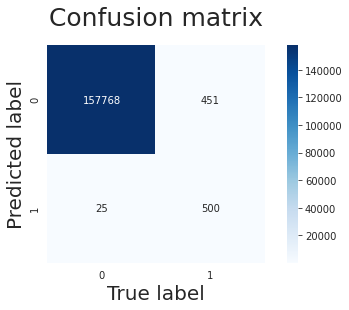

In [82]:
from sklearn.metrics import confusion_matrix

mat_smote = confusion_matrix(test_df[output_feature], predictions_df['fraud_predicted'])

plt.figure(figsize=(8,4))
ax= sns.heatmap(mat_smote.T, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
ax.set_ylim([2,0])
plt.title("Confusion matrix", pad=20, fontsize=25,  FontName='Times New Roman')
plt.xlabel('True label',fontsize=20, FontName='Times New Roman')
plt.ylabel('Predicted label',fontsize=20, FontName='Times New Roman')

The most interpretable metric is the Card Precision@100, which tells us that every day, 9.4% of the cards with the highest fraudulent scores were indeed compromised. Since the percentage of frauds in the test set is 0.6%, this proportion of detected frauds is high, and means that the classifier indeed manages to do much better than chance. 

The interpretation of the AUC ROC and Average Precision is less straightforward. However, by definition, it is known that a random classifier would give an AUC ROC of 0.5, and an Average Precision of 0.006 (the proportion of frauds in the test set). The obtained values are much higher (0.779) and (0.534), confirming the ability of the classifier to provide much better predictions than a random model.

Note: The performances for a random model can be computed by simply setting all predictions to a probability of $0.5$:


In [61]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[20])

,AUC ROC,Average precision,Card Precision@20
0,0.5,0.006,0.015


(Baseline_FDS_Performances_Simulation)=
## Performances using standard prediction models

We now have all the building blocks to train and assess other classifiers. Besides the decision tree with depth 2, let us train four other prediction models: a *decision tree* with unlimited depth, a *logistic regression* model, a *random forest*, and a boosting model (refer to the import cell for library details).  
 
For this purpose, let us first create a dictionary of `sklearn` classifiers that instantiates each of these classifiers. We then train and compute the predictions for each of these classifiers using the `fit_model_and_get_predictions` function.

In [62]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


Let us finally assess the prediction performances of these five models, on the test set and the training set, and their execution times.

In [63]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [64]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.872,0.620,0.109
Decision tree with depth of two,0.779,0.534,0.094
Random forest,0.876,0.706,0.111
XGBoost,0.877,0.715,0.112


In [65]:
# performances on training set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df, 
                                                        type_set='train', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.899,0.678,0.258
Decision tree with depth of two,0.803,0.591,0.242
Random forest,1.000,1.000,0.297
XGBoost,0.917,0.773,0.264


In [66]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times.append(execution_times_model)
        
    return execution_times

In [67]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times

,Training execution time,Prediction execution time
Logistic regression,5.855671,0.035670
Decision tree with depth of two,1.919710,0.020757
Random forest,353.386052,2.626576
XGBoost,58.385864,0.269459


The main takeaways in these performance results are

* All prediction models have learned useful fraud patterns from the training data. This can be seen from the AUC ROC on the test set, which is higher than 0.5 for all classifiers, and an average precision much higher than 0.007. 
* The random forest and boosting models provide better performances (in terms of Average Precision) than logistic regression and decision trees. This is also widely reported in the fraud detection literature. 
* The relative performances of the classifiers differ depending on which performance metrics is used. For example, a decision tree of depth 2 has a lower AUC ROC than a decision tree of unlimited depth, but a higher average precision. Understanding precisely what these performances mean is crucial, and will be addressed in the next chapter. 
* The performance of some classifiers (Random Forest and Decision Tree with unlimited depth) is perfect on the training set (AUC ROC and Average Precision of 1), but lower on the test set. In fact, the decision tree with unlimited depth is actually the worst classifier on the test set in terms of Average Precision. This is an example of a phenomenon called *overfitting*, which should be avoided. Moreover, their link to the target use case should drive the choice of the right classifier for deployment. The meaning of each performance metric will be addressed in the next chapter.
* The execution times for training ensembles of models (Random forest and XGBoost) is significantly higher than decision trees and logistic regression.  